# Combined Recent Surveys
This notebook make predictions for the combined features and cross border predictions.

In [3]:
cd ..

/home/sallinen/Programmation/predicting-poverty-through-time/src


In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [5]:
from lib import estimator_util as eu
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from tqdm import tqdm
from lib import clusters_utils as cl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

In [6]:
sns.set_theme()

In [7]:
complete_df, all_cols = eu.get_data("../data/lsms/processed/_all_real.csv", "../data/cnn_features/resnet_trans_all_countries_hyper.csv", "../data/")

In [8]:
countries = ["NG", "ETH", "TZA", "MW"]
X, _, _, _ = eu.get_recent_osm_features(complete_df, countries, all_cols)
X = pd.DataFrame(X, columns=all_cols)
null_features = X.loc[:, (X == 0).any(axis=0)].keys()

## Heatmap for cross country

In [9]:
def run_combined(df, osm_cols, model, **params) :
    countries = [["NG"], ["ETH"] ,["TZA"], ["MW"], ["NG", "ETH", "TZA", "MW"]]
    results = np.zeros((5,5))
    for i, country in enumerate(countries):
        X, y = eu.get_recent_features(df, country, osm_cols, pca_comp_cnn=5)
        for j, out_country in enumerate(countries):
            X_out, y_out = eu.get_recent_features(df, out_country, osm_cols, pca_comp_cnn=5)
            r, _, m = eu.run_model_out(X, y, X_out, y_out, model, **params)
            results[i,j] = r
    return results

In [ ]:
def heatmap(data, name : string):
    countries = ["Nigeria", "Ethiopia" ,"Tanzania", "Malawi", "Pooled"]
    df_cm = pd.DataFrame(data, index = countries, columns = countries)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cbar_kws={'label': r'$r^2$'})
    plt.xlabel("Country trained on")
    plt.ylabel("Country evaluated on")
    plt.title("Heatmap of the cross country predictions with " + name)
    ax = plt.gca()
    plt.text(-0.1, 1.1, string.ascii_uppercase[0], size=20, weight='bold', transform=ax.transAxes)
    plt.savefig("../figs/cross_country_pooled_{name}.pdf", dpi=600, bbox_inches="tight")

### Using Ridge Regression to compare with the original model

In [ ]:
ridge_results = run_combined(complete_df, all_cols, Ridge, alpha = 1000)

In [ ]:
heatmap(ridge_results, "Ridge")

### Using CatBoost our best model

In [ ]:
catboost_results = run_combined(complete_df, all_cols, CatBoostRegressor, task_type="GPU", random_state=42)


In [ ]:
heatmap(catboost_results, "CatBoost")

## Pooled Dataset

In [10]:
def plot_pooled_results(df, osm_cols, model, **params) :
    years = df.groupby(["year"]).groups.keys()
    year = max(years)
    recent_df_complete = df.loc[df.year == year]
    split_map = cl.split_k_sets(10, lat=recent_df_complete["lat"], lon=recent_df_complete["lon"])
    X, y = eu.get_recent_features(df, ["NG", "ETH", "TZA", "MW"], osm_cols, null_osm_features=null_features, pca_comp_cnn=5)
    r2, y_real, y_predicted, trained_model = eu.run_model(X, y, model, seed=1, kf= cl.folds_from_split(split_map), **params)
    fig = eu.plot_predictions(y_real, y_predicted, r2, "Pooled", "max in Dataset")
    return fig, trained_model


### with Ridge

In [ ]:
fig, _ = plot_pooled_results(complete_df, all_cols, Ridge, alpha = 1000)
fig.savefig("../figs/pooled_max_year_ridge_PCA.pdf", dpi=600, bbox_inches="tight")

### with CatBoost

Learning rate set to 0.037909
0:	learn: 0.6454301	total: 20.4ms	remaining: 20.4s
1:	learn: 0.6395619	total: 29.3ms	remaining: 14.6s
2:	learn: 0.6319069	total: 36.3ms	remaining: 12.1s
3:	learn: 0.6264416	total: 44.6ms	remaining: 11.1s
4:	learn: 0.6202995	total: 51.7ms	remaining: 10.3s
5:	learn: 0.6141871	total: 60.8ms	remaining: 10.1s
6:	learn: 0.6080225	total: 69.2ms	remaining: 9.81s
7:	learn: 0.6014765	total: 79.9ms	remaining: 9.91s
8:	learn: 0.5947065	total: 88.3ms	remaining: 9.72s
9:	learn: 0.5878248	total: 95.7ms	remaining: 9.48s
10:	learn: 0.5811818	total: 102ms	remaining: 9.2s
11:	learn: 0.5754746	total: 111ms	remaining: 9.16s
12:	learn: 0.5700281	total: 119ms	remaining: 9.06s
13:	learn: 0.5646157	total: 128ms	remaining: 9.02s
14:	learn: 0.5611929	total: 138ms	remaining: 9.05s
15:	learn: 0.5558976	total: 145ms	remaining: 8.89s
16:	learn: 0.5520054	total: 152ms	remaining: 8.78s
17:	learn: 0.5485098	total: 162ms	remaining: 8.82s
18:	learn: 0.5426259	total: 170ms	remaining: 8.79s
19

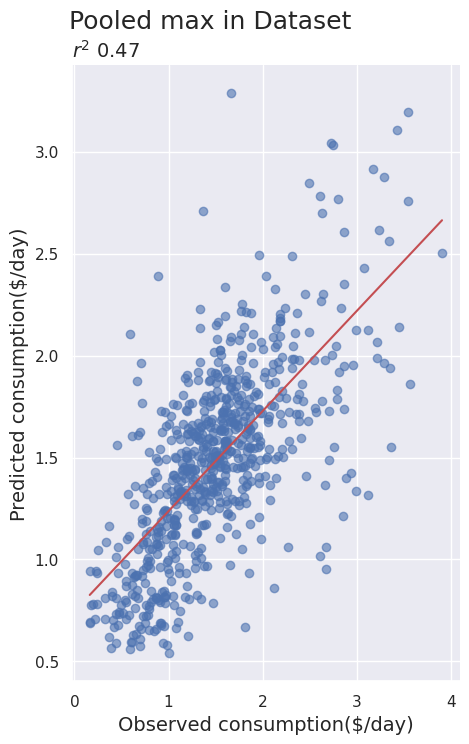

In [11]:
fig, model = plot_pooled_results(complete_df, all_cols, CatBoostRegressor, task_type="GPU", random_state=42)
fig.savefig("../figs/pooled_max_year_catboost_PCA.pdf", dpi=600, bbox_inches="tight")

/tmp/ipykernel_430/3493362337.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_features, fontsize=8, rotation=90)


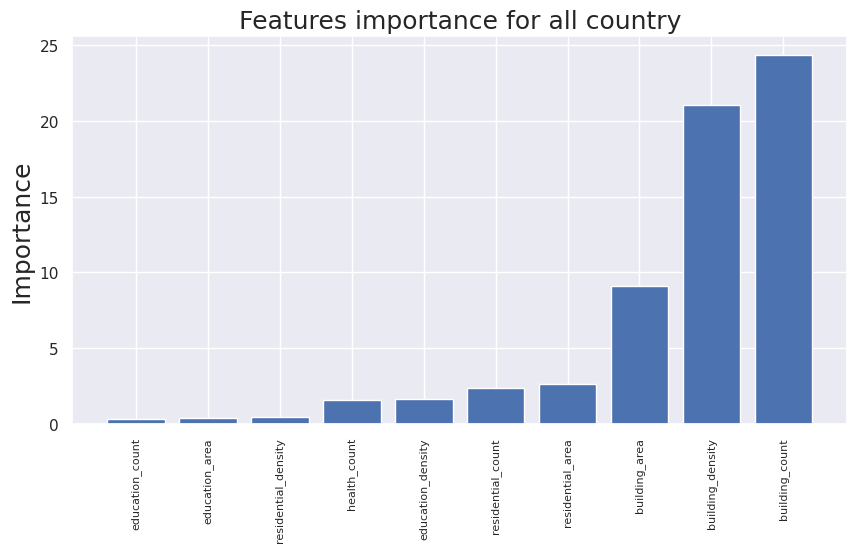

In [26]:
def features_importance(model) :
    importance = model.feature_importances_
    fig, ax = plt.subplots(figsize=(10, 20))
    sorted_importance, sorted_features = zip(*sorted(zip(importance[:10], all_cols[:10])))
    ax.bar(sorted_features, sorted_importance)
    ax.set_xticklabels(sorted_features, fontsize=8, rotation=90)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*0.5)
    plt.ylabel('Importance', fontsize=18)
    plt.title(f'Features importance for all country', fontsize=18)
    plt.show()
    fig.savefig("../figs/features_importance_combined_PCA_15.pdf", dpi=600, bbox_inches="tight")

features_importance(model)